In [19]:
import gridemissions as ge
from power_dashboard.gridemissions_utils import load_bulk
import pandas as pd
from pathlib import Path
from typing import Union, List
import matplotlib.pyplot as plt

In [2]:
elec = load_bulk("../data/interim/gridemissions", "elec")

In [3]:
co2i = load_bulk("../data/interim/gridemissions", "co2i")

In [4]:
co2 = load_bulk("../data/interim/gridemissions", "co2")

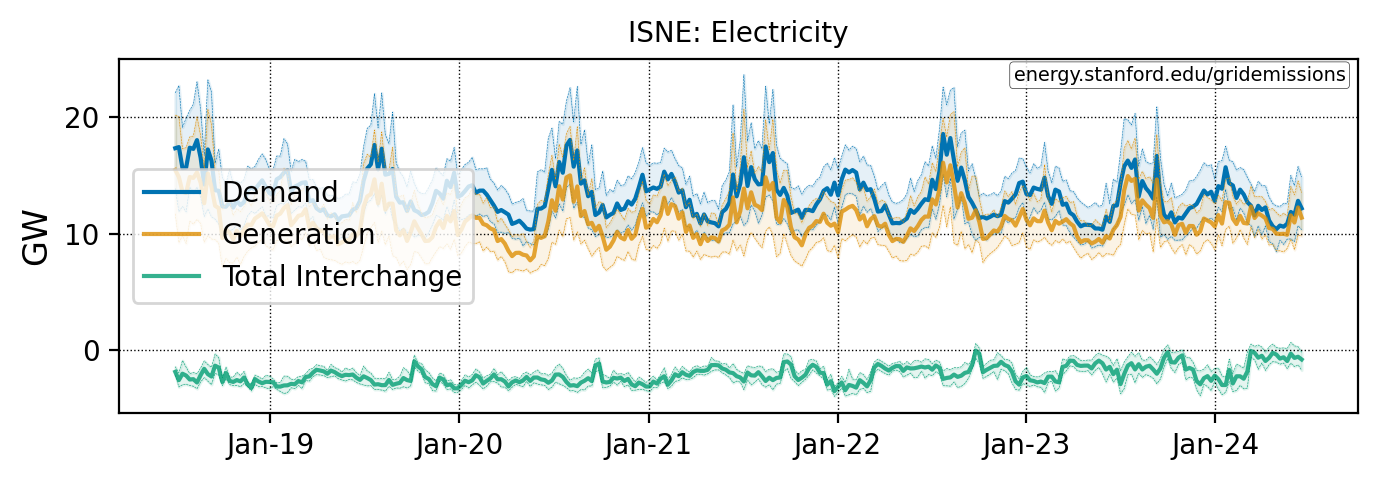

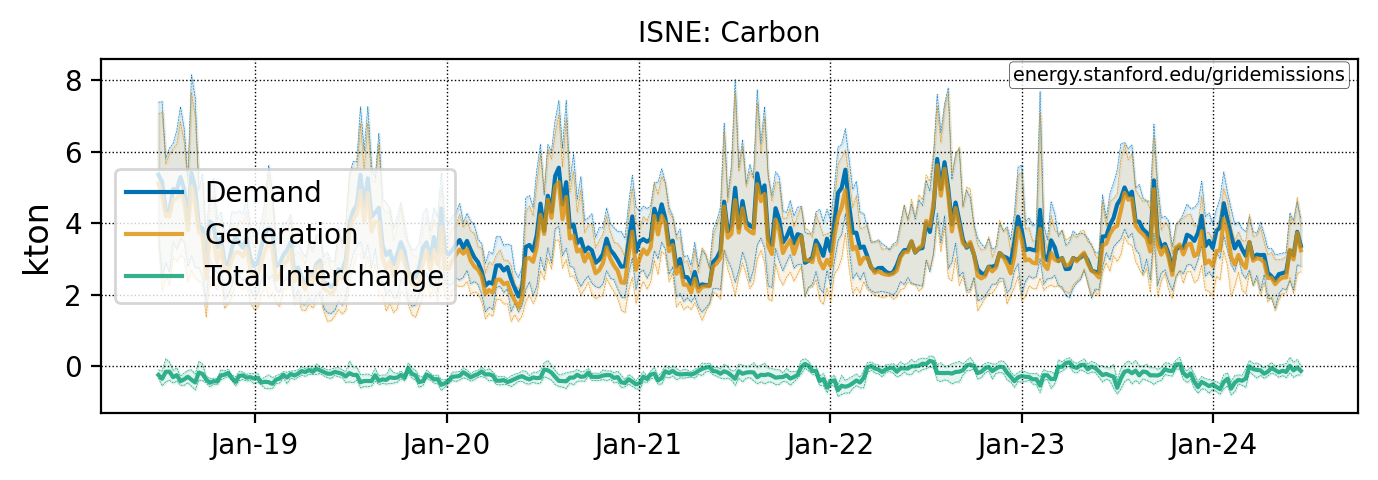

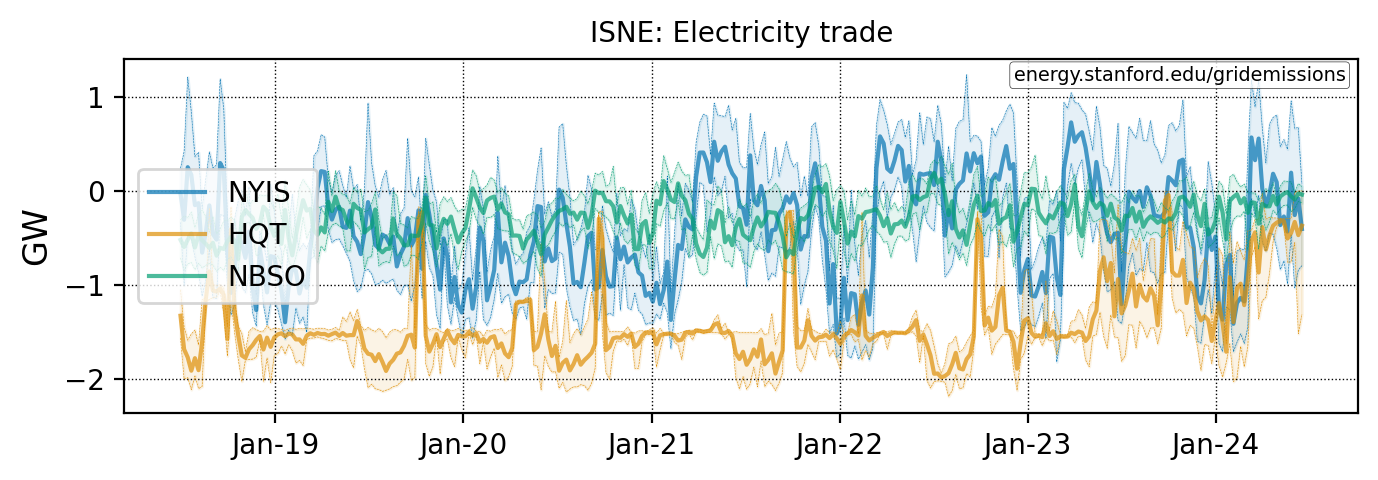

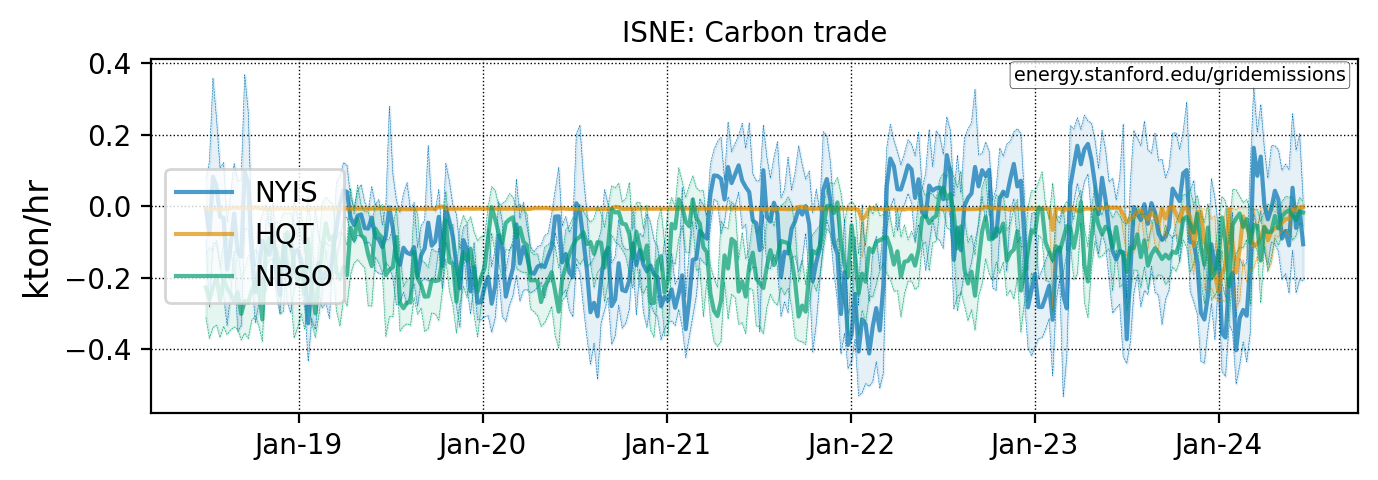

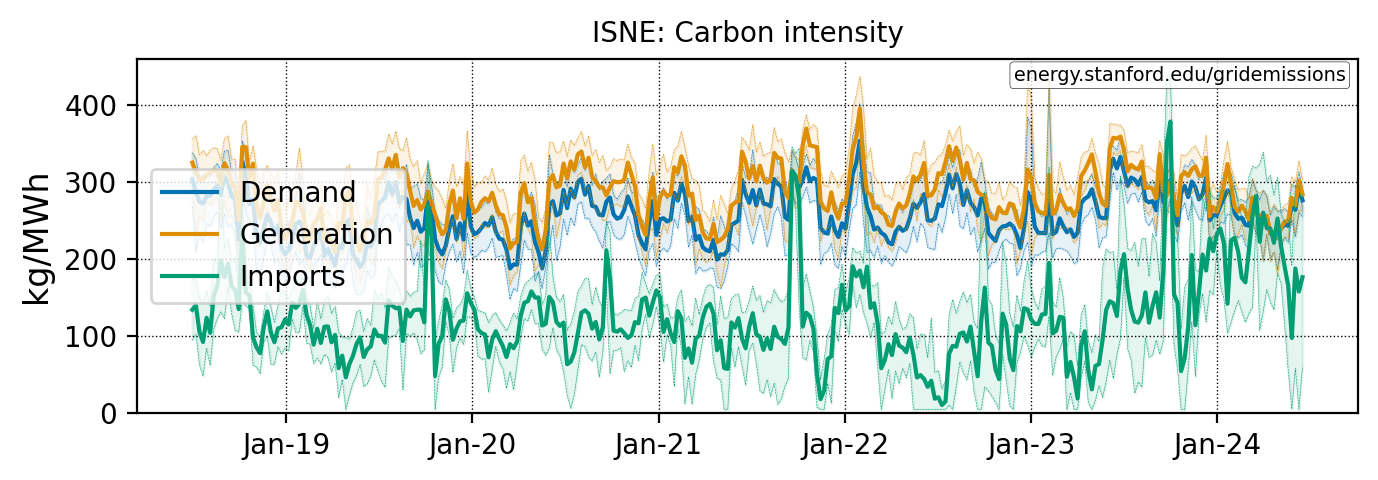

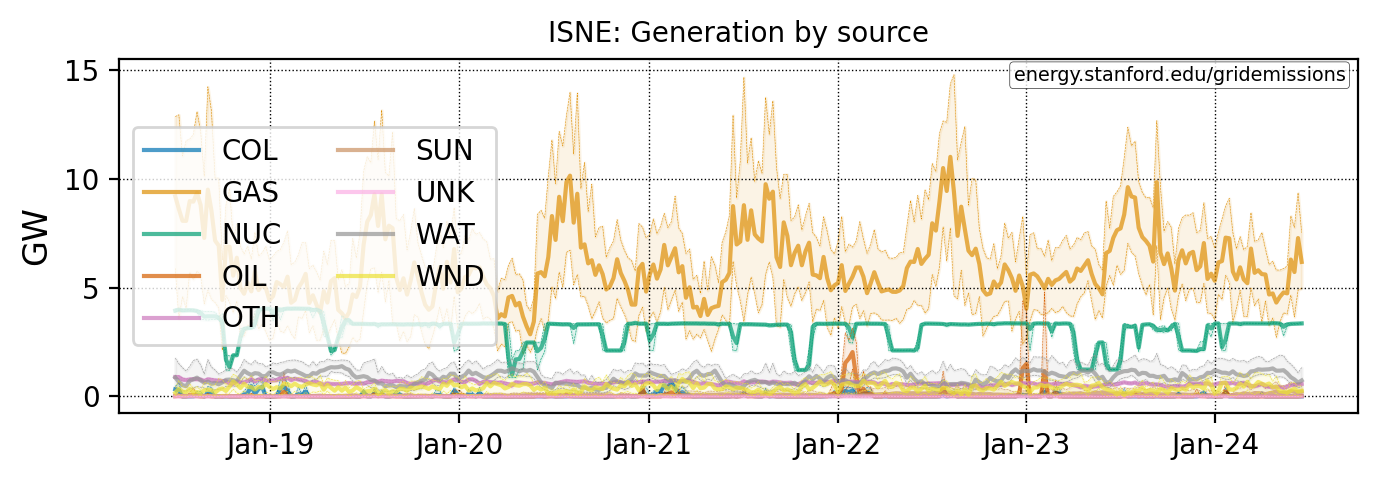

In [5]:
from gridemissions.viz import set_plots
from gridemissions.viz.reports import timeseries_report

COLORS, PAGE_WIDTH, ROW_HEIGHT = set_plots()
timeseries_report(co2, elec, regions=["ISNE"])

## Forecasting

My initial goal is to implement a baseline univariate forecasting model for the hourly carbon intensity time-series and evaluate its performance on intraday timescales (1-24 hours ahead).  I will follow the methods reviewed in "A comparison of univariate methods for forecasting electricity demand up to a day ahead" by Taylor et al (2006)

In this paper, they fit models using 30 weeks of hourly observations for electricity demand.  "As in many other studies of electricity demand, prior to fitting and evaluating methods, we elected to smooth out the dspecial daysT, such as bank holidays, as their inclusion is likely to be unhelpful in our comparison of methods."

"For each series, we used the first 20 weeks of data to estimate method parameters and the remaining 10 weeks to evaluate post-sample accuracy of forecasts up to 24 hours ahead."

The methods evaluated were:

**Double Seasonal ARMA model**

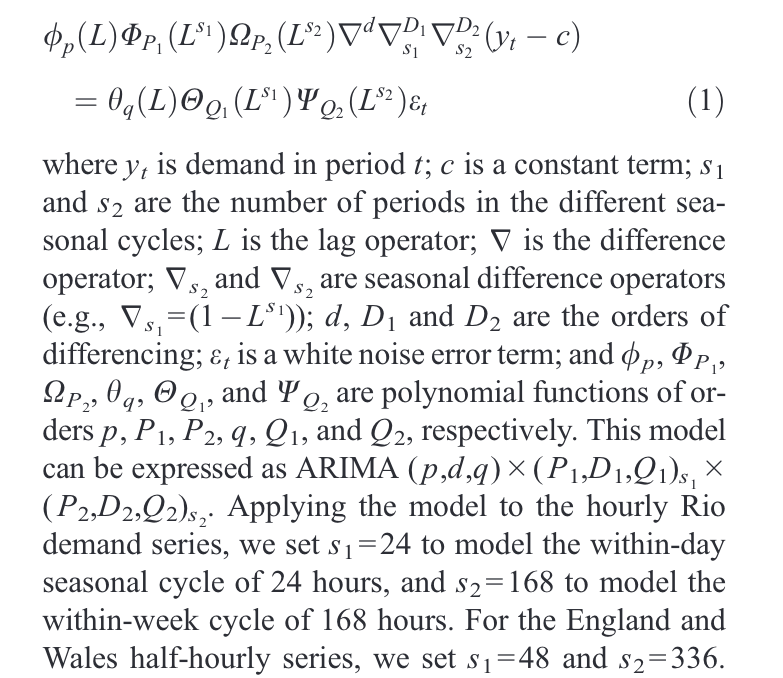

**Exponential smoothing for double seasonality**

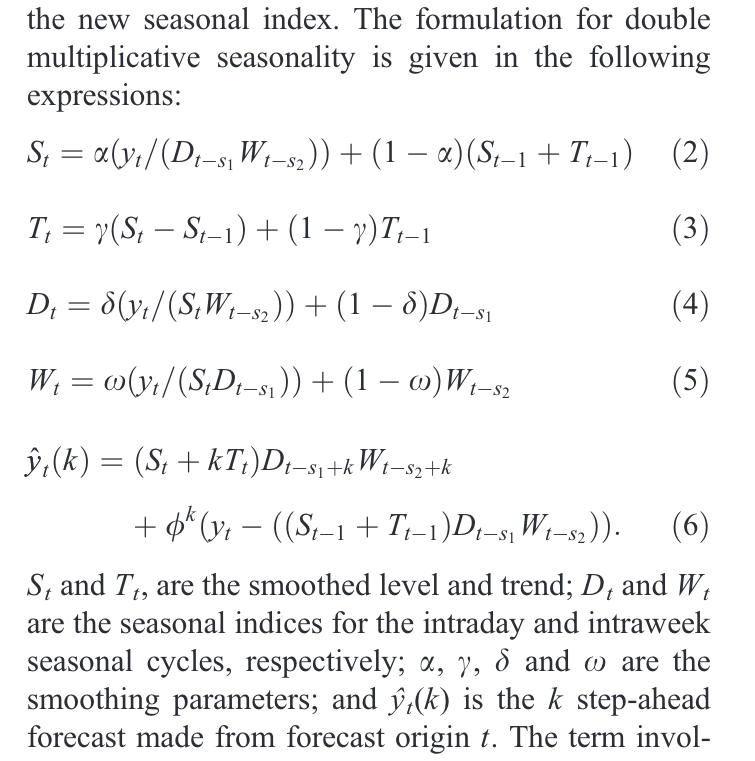

In [9]:
all_ts = co2i.df.reset_index().melt(id_vars=['period'], var_name="region", value_name="CO2 Intensity").dropna()
all_ts

period       region  CO2 Intensity
0       2018-07-01 05:00:00  CO2i_AECI_D     805.595336
1       2018-07-01 06:00:00  CO2i_AECI_D     744.287362
2       2018-07-01 07:00:00  CO2i_AECI_D     776.005106
3       2018-07-01 08:00:00  CO2i_AECI_D     763.689075
4       2018-07-01 09:00:00  CO2i_AECI_D     742.131991
...                     ...          ...            ...
3869211 2019-01-01 02:00:00  CO2i_OVEC_D     976.902309
3869212 2019-01-01 03:00:00  CO2i_OVEC_D     985.903550
3869213 2019-01-01 04:00:00  CO2i_OVEC_D     984.761680
3869214 2019-01-01 05:00:00  CO2i_OVEC_D     972.396089
3869217 2019-01-01 08:00:00  CO2i_OVEC_D     949.965737

[3748439 rows x 3 columns]

In [11]:
import pandas as pd
df = all_ts.loc[all_ts['region'] == 'CO2i_ISNE_D']
df.columns = ['ds', 'unique_id', 'y']
df.tail()


ds    unique_id           y
1514578 2024-06-15 03:00:00  CO2i_ISNE_D  290.016321
1514579 2024-06-15 04:00:00  CO2i_ISNE_D  283.324206
1514580 2024-06-15 05:00:00  CO2i_ISNE_D  291.796152
1514581 2024-06-15 06:00:00  CO2i_ISNE_D  285.924739
1514582 2024-06-15 07:00:00  CO2i_ISNE_D  277.681349

In [12]:
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)


/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/plotting.py:34: SyntaxWarning: invalid escape sequence '\('
  models_pat = r"|".join(models).replace("(", "\(").replace(")", "\)")
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/plotting.py:34: SyntaxWarning: invalid escape sequence '\)'
  models_pat = r"|".join(models).replace("(", "\(").replace(")", "\)")


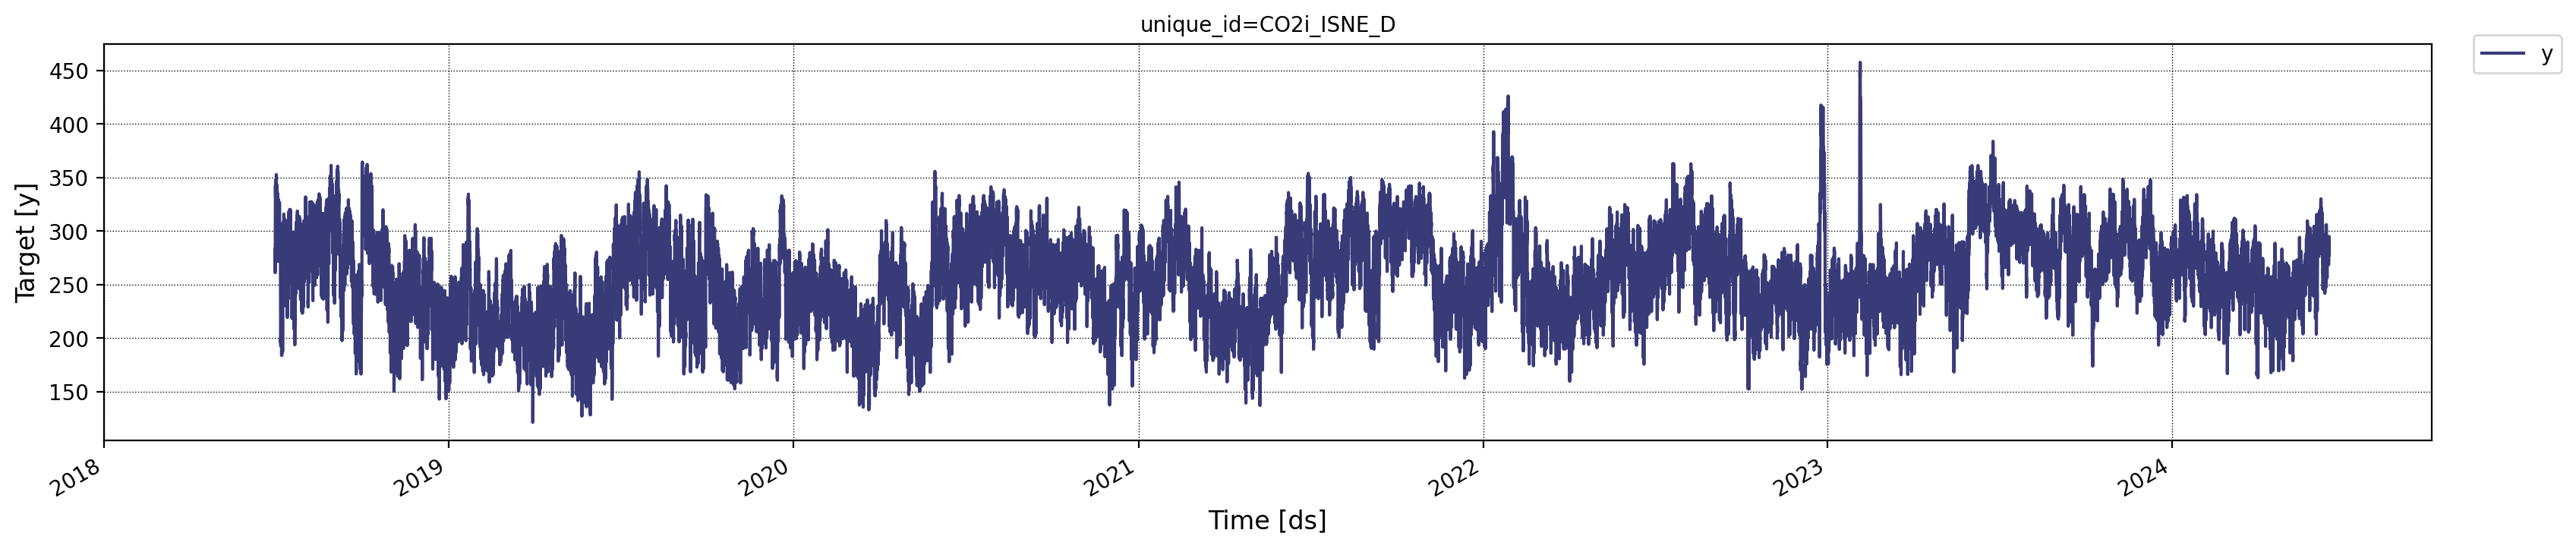

In [13]:
from statsforecast import StatsForecast
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA


StatsForecast.plot(df)

In [14]:
# Create a list of models and instantiation parameters

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA() # model used to forecast trend
)]


In [15]:
sf = StatsForecast(
    models=models, # model used to fit each time series
    freq='H', # frequency of the data
)


In [16]:
sf = sf.fit(df=df)


In [17]:
sf.fitted_[0, 0].model_


data       trend  seasonal24  seasonal168  remainder
0      282.989417  336.101816  -18.360141   -24.890644  -9.861613
1      273.393594  335.639453  -23.843749   -26.803636 -11.598475
2      274.670704  335.177177  -28.044187   -25.972909  -6.489377
3      273.813093  334.714991  -28.618858   -23.984585  -8.298455
4      269.970188  334.252898  -29.354921   -24.533088 -10.394701
...           ...         ...         ...          ...        ...
52222  290.016321  271.979312   17.884769    -1.211788   1.364029
52223  283.324206  271.955355   12.644421    -0.563648  -0.711922
52224  291.796152  271.931971    9.828360    -5.129385  15.165205
52225  285.924739  271.909156    2.993412    -8.200548  19.222719
52226  277.681349  271.886904   -2.836012    -8.288202  16.918658

[52227 rows x 5 columns]

In [22]:
sf.fitted_[0, 0].model_.tail(24 * 28)


data       trend  seasonal24  seasonal168  remainder
51555  226.256586  248.576748    0.688839   -11.060353 -11.948648
51556  227.869731  248.735238    2.110063   -12.786076 -10.189494
51557  226.764793  248.895662   -1.367801   -15.056792  -5.706275
51558  216.026703  249.057955   -6.941263   -17.463587  -8.626402
51559  203.918040  249.222049   -4.026885   -22.081658 -19.195465
...           ...         ...         ...          ...        ...
52222  290.016321  271.979312   17.884769    -1.211788   1.364029
52223  283.324206  271.955355   12.644421    -0.563648  -0.711922
52224  291.796152  271.931971    9.828360    -5.129385  15.165205
52225  285.924739  271.909156    2.993412    -8.200548  19.222719
52226  277.681349  271.886904   -2.836012    -8.288202  16.918658

[672 rows x 5 columns]

In [23]:
crossvalidation_df = sf.cross_validation(
    df = df,
    h = 24,
    step_size = 24,
    n_windows = 10,
  )


/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [24]:
crossvalidation_df.head()

ds              cutoff           y        MSTL
unique_id                                                                  
CO2i_ISNE_D 2024-06-05 08:00:00 2024-06-05 07:00:00  298.402466  295.213104
CO2i_ISNE_D 2024-06-05 09:00:00 2024-06-05 07:00:00  297.846588  296.861755
CO2i_ISNE_D 2024-06-05 10:00:00 2024-06-05 07:00:00  298.329865  298.811005
CO2i_ISNE_D 2024-06-05 11:00:00 2024-06-05 07:00:00  298.371460  310.895691
CO2i_ISNE_D 2024-06-05 12:00:00 2024-06-05 07:00:00  292.477905  311.049042

In [30]:
%matplotlib inline

cv_df = crossvalidation_df.rename(columns = {'y' : 'actual'}).reset_index() # rename actual values

cutoff = cv_df['cutoff'].unique()

for k in range(len(cutoff)):
    cv = cv_df[cv_df['cutoff'] == cutoff[k]]
    StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff'])


In [34]:
from utilsforecast.plotting import plot_series
from pandas import DataFrame
from typing import Optional, Dict
import numpy as np
from utilsforecast.validation import ensure_time_dtype, validate_freq
import warnings

def revised_plot(
        df: DataFrame,
        forecasts_df: Optional[DataFrame] = None,
        unique_ids: Union[Optional[List[str]], np.ndarray] = None,
        plot_random: bool = True,
        models: Optional[List[str]] = None,
        level: Optional[List[float]] = None,
        max_insample_length: Optional[int] = None,
        plot_anomalies: bool = False,
        engine: str = "matplotlib",
        id_col: str = "unique_id",
        time_col: str = "ds",
        target_col: str = "y",
        resampler_kwargs: Optional[Dict] = None,
        ax: Optional[Union[plt.Axes, np.ndarray, "plotly.graph_objects.Figure"]] = None,
    ):
        """Plot forecasts and insample values.

        Parameters
        ----------
        {df}
        forecasts_df : pandas or polars DataFrame, optional (default=None)
            DataFrame ids, times and models.
        unique_ids : list of str, optional (default=None)
            ids to plot. If None, they're selected randomly.
        plot_random : bool (default=True)
            Select time series to plot randomly.
        models : List[str], optional (default=None)
            List of models to plot.
        level : List[float], optional (default=None)
            List of prediction intervals to plot if paseed.
        max_insample_length : int, optional (default=None)
            Max number of train/insample observations to be plotted.
        plot_anomalies : bool (default=False)
            Plot anomalies for each prediction interval.
        engine : str (default='matplotlib')
            Library used to plot. 'plotly', 'plotly-resampler' or 'matplotlib'.
        {id_col}
        {time_col}
        {target_col}
        resampler_kwargs : dict
            Kwargs to be passed to plotly-resampler constructor.
            For further custumization ("show_dash") call the method,
            store the plotting object and add the extra arguments to
            its `show_dash` method.
        """
        from utilsforecast.plotting import plot_series

        df = ensure_time_dtype(df, time_col)
        if isinstance(df, pd.DataFrame) and df.index.name == id_col:
            warnings.warn(
                "Passing the ids as the index is deprecated. "
                "Please provide them as a column instead.",
                category=FutureWarning,
            )
            df = df.reset_index()
        if forecasts_df is not None:
            forecasts_df = ensure_time_dtype(forecasts_df, time_col)
        if isinstance(forecasts_df, pd.DataFrame) and forecasts_df.index.name == id_col:
            warnings.warn(
                "Passing the ids as the index is deprecated. "
                "Please provide them as a column instead.",
                category=FutureWarning,
            )
            forecasts_df = forecasts_df.reset_index()
        return plot_series(
            df=df,
            forecasts_df=forecasts_df,
            ids=unique_ids,
            plot_random=plot_random,
            models=models,
            level=level,
            max_insample_length=max_insample_length,
            plot_anomalies=plot_anomalies,
            engine=engine,
            resampler_kwargs=resampler_kwargs,
            palette="tab20b",
            id_col=id_col,
            time_col=time_col,
            target_col=target_col,
            ax=ax,
        )

In [39]:
cv_df = crossvalidation_df.rename(columns = {'y' : 'actual'}).reset_index() # rename actual values

cutoff = cv_df['cutoff'].unique()

# fig, axs = plt.subplots(len(cutoff), 1)

cv_df['cutoff'].unique()

# for k in range(len(cutoff)):
#     cv = cv_df[cv_df['cutoff'] == cutoff[k]]
#     revised_plot(df, cv.loc[:, cv.columns != 'cutoff'], axs[k])

<DatetimeArray>
['2024-06-05 07:00:00', '2024-06-06 07:00:00', '2024-06-07 07:00:00',
 '2024-06-08 07:00:00', '2024-06-09 07:00:00', '2024-06-10 07:00:00',
 '2024-06-11 07:00:00', '2024-06-12 07:00:00', '2024-06-13 07:00:00',
 '2024-06-14 07:00:00']
Length: 10, dtype: datetime64[ns]

In [40]:
forecasts = sf.predict(h=24, level=[90])
forecasts.head()

/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:438: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


ds        MSTL  MSTL-lo-90  MSTL-hi-90
unique_id                                                          
CO2i_ISNE_D 2024-06-15 08:00:00  272.143066  264.467987  279.818115
CO2i_ISNE_D 2024-06-15 09:00:00  270.389893  258.839050  281.940765
CO2i_ISNE_D 2024-06-15 10:00:00  266.761810  252.468567  281.055054
CO2i_ISNE_D 2024-06-15 11:00:00  268.535461  252.084457  284.986511
CO2i_ISNE_D 2024-06-15 12:00:00  259.349701  241.098999  277.600403

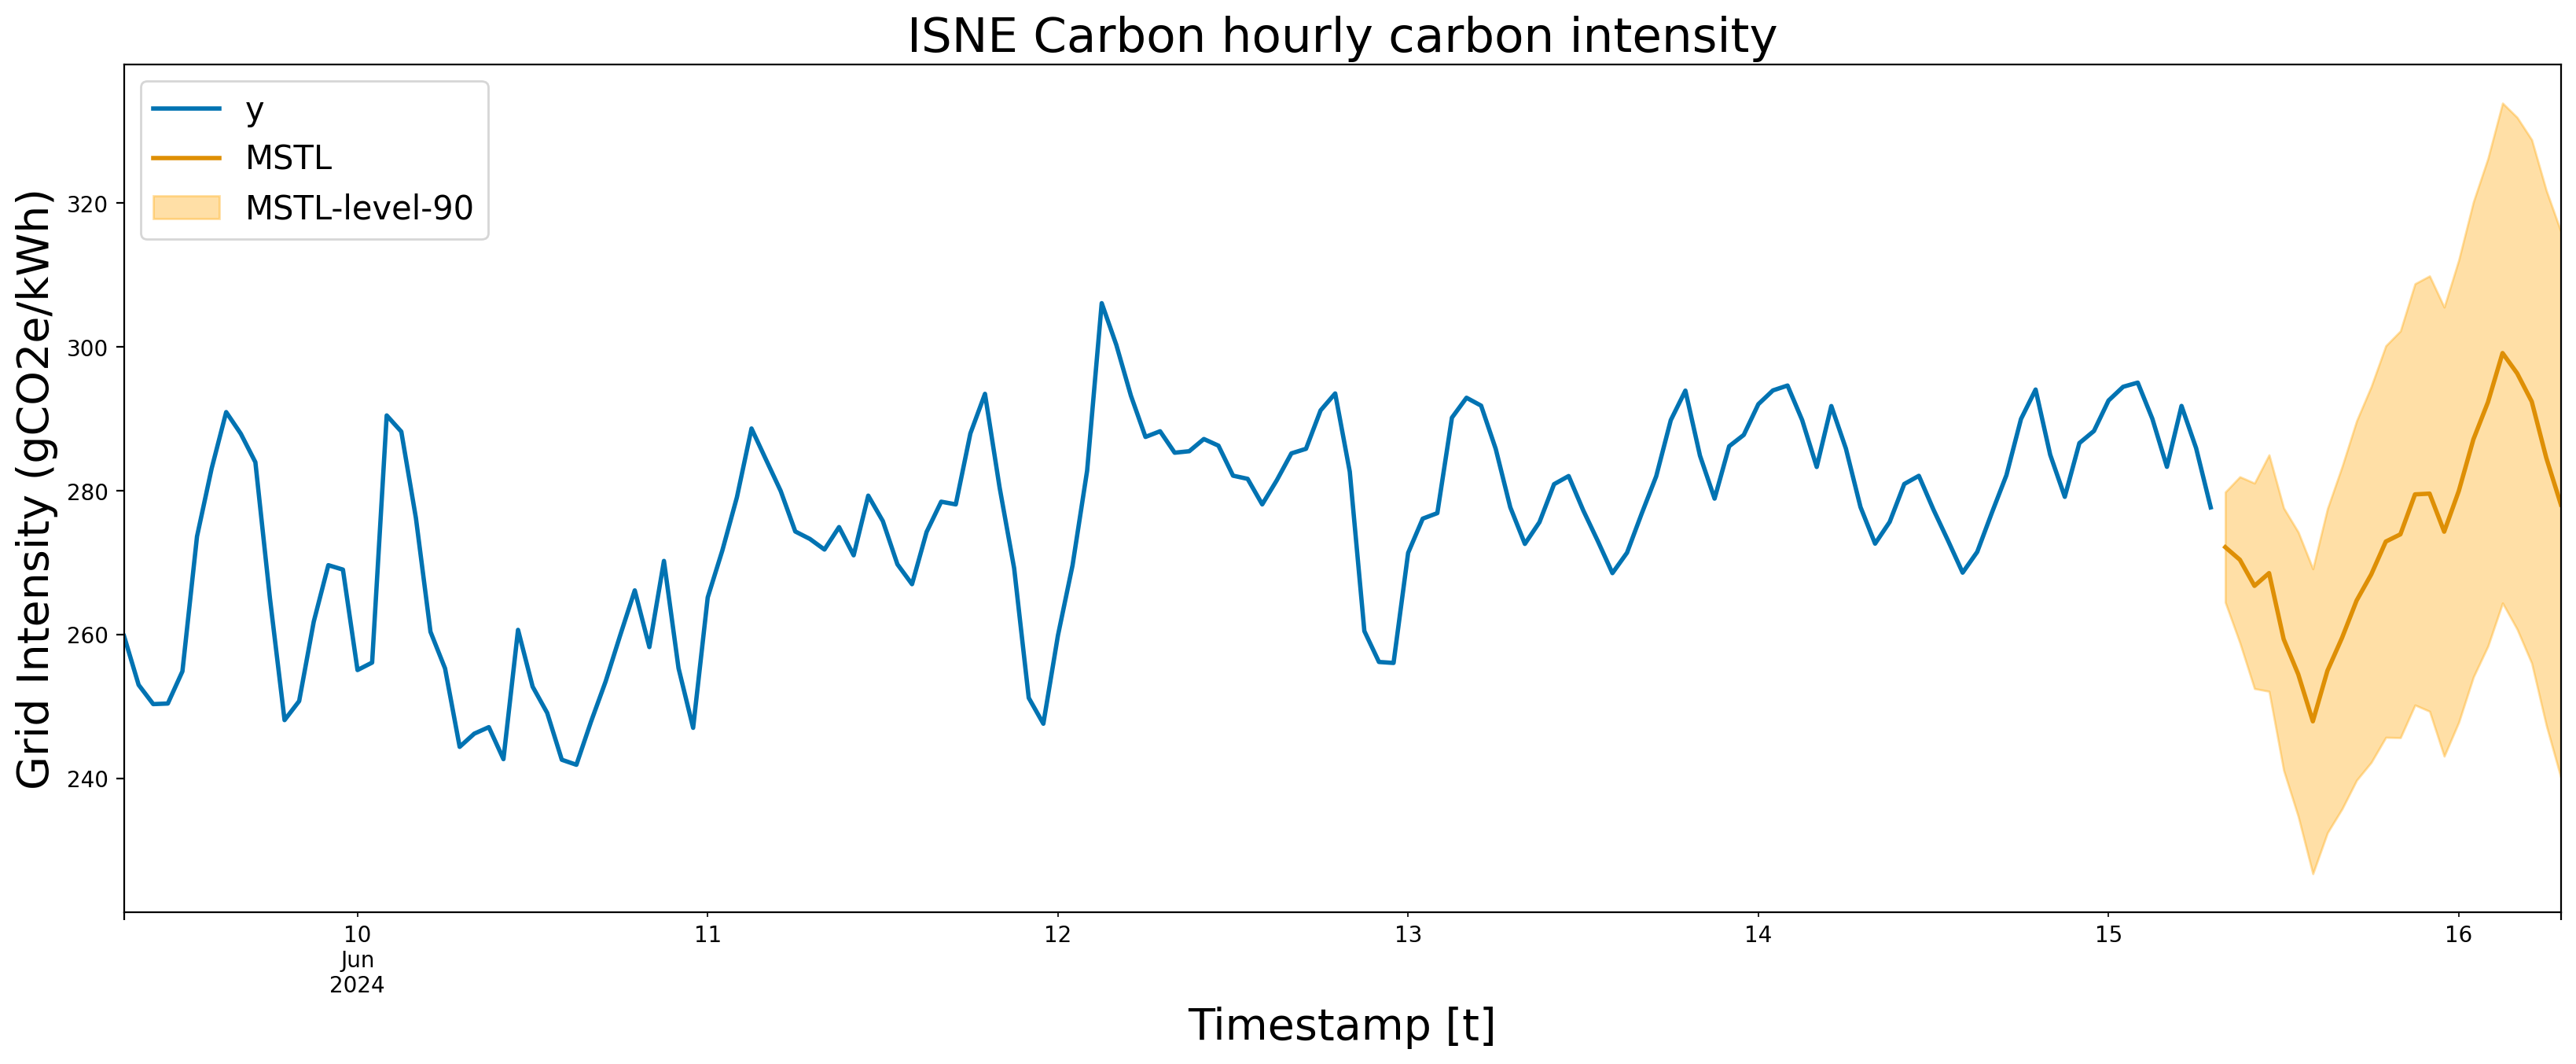

In [42]:
_, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([df, forecasts]).set_index('ds').tail(24 * 7)
df_plot[['y', 'MSTL']].plot(ax=ax, linewidth=2)
ax.fill_between(df_plot.index,
                df_plot['MSTL-lo-90'],
                df_plot['MSTL-hi-90'],
                alpha=.35,
                color='orange',
                label='MSTL-level-90')
ax.set_title('ISNE Carbon hourly carbon intensity', fontsize=22)
ax.set_ylabel('Grid Intensity (gCO2e/kWh)', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

## Evaluate performance

In [50]:
from datasetsforecast.losses import (
    mae, mape, mase, rmse, smape
)
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, SeasonalNaive
from time import time

In [45]:
#Keep one week of data for test
df_test = df.tail(24*7)
df_train = df.drop(df_test.index)


In [46]:
mstl = MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA() # model used to forecast trend
)

In [49]:
sf = StatsForecast(
    models=[mstl, SeasonalNaive(season_length=24)], # add SeasonalNaive model to the list
    freq='H'
)

In [51]:
init = time()
sf = sf.fit(df=df_train)
forecasts_test = sf.predict(h=len(df_test), level=[90])
end = time()
forecasts_test.head()


/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/utilsforecast/processing.py:438: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/alexhasha/Library/Caches/pypoetry/virtualenvs/power-dashboard-zNqpkPiA-py3.12/lib/python3.12/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


ds  ...  SeasonalNaive-hi-90
unique_id                        ...                     
CO2i_ISNE_D 2024-06-08 08:00:00  ...           414.683197
CO2i_ISNE_D 2024-06-08 09:00:00  ...           408.382568
CO2i_ISNE_D 2024-06-08 10:00:00  ...           398.752594
CO2i_ISNE_D 2024-06-08 11:00:00  ...           417.660522
CO2i_ISNE_D 2024-06-08 12:00:00  ...           406.287109

[5 rows x 7 columns]

In [54]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(24 * 14)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2)
    colors = ['orange', 'green', 'red']
    for model, color in zip(models, colors):
        ax.fill_between(df_plot.index,
                        df_plot[f'{model}-lo-90'],
                        df_plot[f'{model}-hi-90'],
                        alpha=.35,
                        color=color,
                        label=f'{model}-level-90')
    ax.set_title('Grid Intensity Hourly', fontsize=22)
    ax.set_ylabel('Grid Intensity (gCO2e/kWh)', fontsize=20)
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()


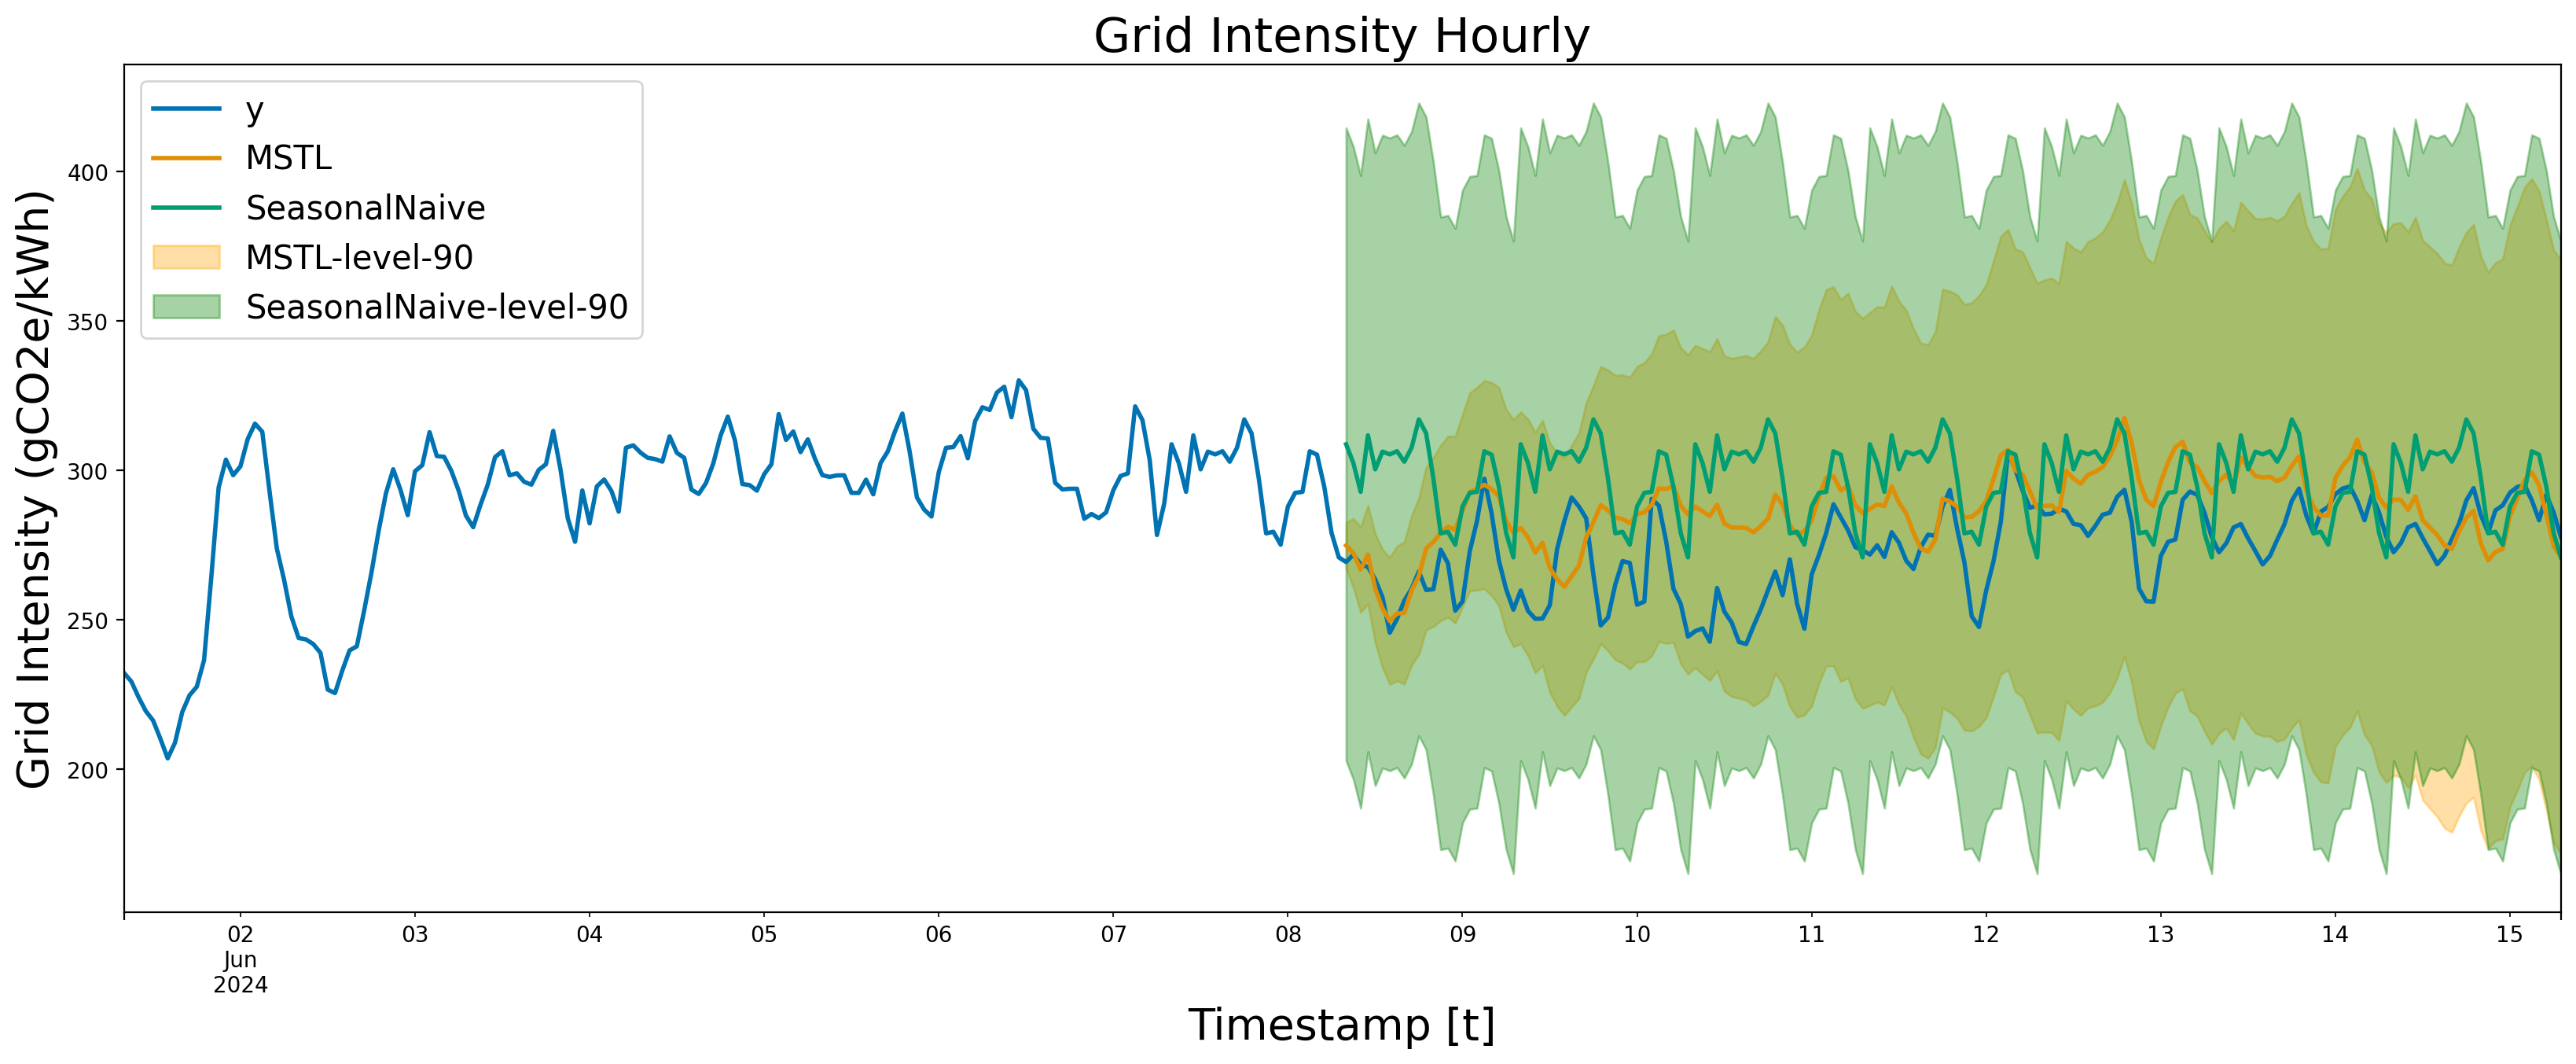

In [55]:
plot_forecasts(df_train, df_test, forecasts_test, models=['MSTL', 'SeasonalNaive'])


In [56]:
def evaluate_performace(y_hist, y_true, y_pred, models):
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values,
                                                 y_true[model].values,
                                                 y_hist['y'].values, seasonality=24)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T


In [57]:
evaluate_performace(df_train, df_test, forecasts_test, models=['MSTL', 'SeasonalNaive'])


mase        mae      mape       rmse     smape
MSTL           0.881709  15.969658  5.991751  19.331420  5.752676
SeasonalNaive  1.380220  24.998760  9.395967  29.683304  8.806714

## Scratch

In [74]:
ba = "ISNE"
co2iD = (
        co2.get_data(region=ba, field="D")
        / elec.get_data(region=ba, field="D")
    )
co2iD

period
2018-07-01 05:00:00    282.989417
2018-07-01 06:00:00    273.393594
2018-07-01 07:00:00    274.670704
2018-07-01 08:00:00    273.813093
2018-07-01 09:00:00    269.970188
                          ...    
2024-06-15 03:00:00    290.016321
2024-06-15 04:00:00    283.324206
2024-06-15 05:00:00    291.796152
2024-06-15 06:00:00    285.924739
2024-06-15 07:00:00    277.681349
Length: 52227, dtype: float64

In [78]:
co2iD2 = co2i.get_data(region=ba, field="D")

In [82]:
import numpy as np
np.allclose(co2iD, co2iD2, equal_nan=True)

False

In [84]:
co2iD.values.flatten()[np.argmax(np.abs(co2iD - co2iD2))]

348.01847818886034

<Axes: xlabel='period'>

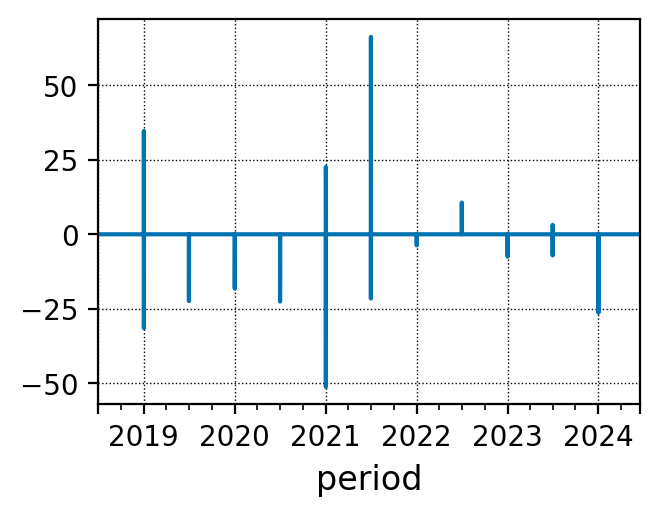

In [87]:
(co2iD - co2iD2).plot()

In [79]:
pd.DataFrame({"v1": co2iD.loc[co2iD != co2iD2], "v2": co2iD2.loc[co2iD != co2iD2]})

v1          v2
period                                     
2018-07-01 09:00:00  269.970188  269.970188
2018-07-01 10:00:00  267.625136  267.625136
2018-07-01 16:00:00  330.809785  330.809785
2018-07-01 17:00:00  337.997439  337.997439
2018-07-02 01:00:00  347.848725  347.848725
...                         ...         ...
2024-06-14 14:00:00  268.599752  268.599752
2024-06-14 15:00:00  271.489138  271.489138
2024-06-14 17:00:00  282.156856  282.156856
2024-06-15 02:00:00  295.039423  295.039423
2024-06-15 05:00:00  291.796152  291.796152

[21906 rows x 2 columns]

In [64]:
co2i.df.index

DatetimeIndex(['2018-07-01 05:00:00', '2018-07-01 06:00:00',
               '2018-07-01 07:00:00', '2018-07-01 08:00:00',
               '2018-07-01 09:00:00', '2018-07-01 10:00:00',
               '2018-07-01 11:00:00', '2018-07-01 12:00:00',
               '2018-07-01 13:00:00', '2018-07-01 14:00:00',
               ...
               '2024-06-14 22:00:00', '2024-06-14 23:00:00',
               '2024-06-15 00:00:00', '2024-06-15 01:00:00',
               '2024-06-15 02:00:00', '2024-06-15 03:00:00',
               '2024-06-15 04:00:00', '2024-06-15 05:00:00',
               '2024-06-15 06:00:00', '2024-06-15 07:00:00'],
              dtype='datetime64[ns]', name='period', length=52227, freq=None)

In [48]:
import numpy as np

def filter_cols(gd: Union[pd.DataFrame, ge.GraphData], balancing_regions: List[str]) -> pd.DataFrame:
    """ """
    if isinstance(gd, pd.DataFrame):
        df = gd
    elif isinstance(gd, ge.GraphData):
        df = gd.df
    else:
        raise ValueError(f"Unexpected type for gd: {type(gd)}")

    cols_to_keep = [col for col in df.columns if np.any([br in col for br in balancing_regions])]
    return df.loc[:, cols_to_keep]

def load_bulk2(
        path: Union[str, Path],
        balancing_region: Union[str, List[str]],
        which: Union[str, List[str]] = ["elec"],
        ) -> pd.DataFrame:

    if isinstance(balancing_region, str):
        balancing_regions = [balancing_region]
    if isinstance(which, str):
        which = [which]
    if not set(which).issubset(["elec", "co2", "co2i", "raw", "basic", "rolling", "opt"]):
        raise ValueError(f"Unexpected value for which: {which}")
    if isinstance(path, str):
        path = Path(path)

    files = [f for f in path.iterdir() if f.stem.split("_")[-1] in which]
    result = pd.concat(
            [filter_cols(
                pd.read_csv(path, index_col=0, parse_dates=True),
                balancing_regions,
                ) for path in files
                ],
            axis=0,
        )
    result.sort_index(inplace=True)
    result = result[~result.index.duplicated(keep="last")]

    return result

In [49]:
result = load_bulk("../data/interim/gridemissions", "ISNE", ["elec", "co2i"])

In [51]:
print(list(result.columns))

['E_ISNE_NG', 'E_ISNE_D', 'E_ISNE_TI', 'E_ISNE-NYIS_ID', 'E_ISNE-HQT_ID', 'E_ISNE-NBSO_ID', 'E_NYIS-ISNE_ID', 'E_HQT-ISNE_ID', 'E_NBSO-ISNE_ID', 'E_ISNE_COL', 'E_ISNE_GAS', 'E_ISNE_NUC', 'E_ISNE_OIL', 'E_ISNE_OTH', 'E_ISNE_SUN', 'E_ISNE_UNK', 'E_ISNE_WAT', 'E_ISNE_WND', 'CO2i_ISNE_D']


In [56]:
result.loc["2020-07-01 03:00:00"]

E_ISNE_NG                NaN
E_ISNE_D                 NaN
E_ISNE_TI                NaN
E_ISNE-NYIS_ID           NaN
E_ISNE-HQT_ID            NaN
E_ISNE-NBSO_ID           NaN
E_NYIS-ISNE_ID           NaN
E_HQT-ISNE_ID            NaN
E_NBSO-ISNE_ID           NaN
E_ISNE_COL               NaN
E_ISNE_GAS               NaN
E_ISNE_NUC               NaN
E_ISNE_OIL               NaN
E_ISNE_OTH               NaN
E_ISNE_SUN               NaN
E_ISNE_UNK               NaN
E_ISNE_WAT               NaN
E_ISNE_WND               NaN
CO2i_ISNE_D       265.823049
Name: 2020-07-01 03:00:00, dtype: float64

In [16]:
result.df["E_ISNE_GAS"]

period
2018-07-01 05:00:00    7063.746853
2018-07-01 06:00:00    6379.167973
2018-07-01 07:00:00    6351.119715
2018-07-01 08:00:00    6206.892876
2018-07-01 09:00:00    5926.454104
                          ...     
2024-06-15 03:00:00    7474.313405
2024-06-15 04:00:00    6484.059690
2024-06-15 05:00:00    6125.695667
2024-06-15 06:00:00    5723.066305
2024-06-15 07:00:00    5234.787745
Name: E_ISNE_GAS, Length: 52227, dtype: float64

In [17]:
[col for col in result.df.columns if col.startswith("E_ISNE")]

['E_ISNE_NG',
 'E_ISNE_D',
 'E_ISNE_TI',
 'E_ISNE-NYIS_ID',
 'E_ISNE-HQT_ID',
 'E_ISNE-NBSO_ID',
 'E_ISNE_COL',
 'E_ISNE_GAS',
 'E_ISNE_NUC',
 'E_ISNE_OIL',
 'E_ISNE_OTH',
 'E_ISNE_SUN',
 'E_ISNE_UNK',
 'E_ISNE_WAT',
 'E_ISNE_WND']

In [18]:
result.regions

['AECI',
 'AEC',
 'AVA',
 'AVRN',
 'AZPS',
 'BANC',
 'BPAT',
 'CHPD',
 'CISO',
 'CPLE',
 'CPLW',
 'DEAA',
 'DOPD',
 'DUK',
 'EPE',
 'ERCO',
 'FMPP',
 'FPC',
 'FPL',
 'GCPD',
 'GLHB',
 'GRID',
 'GRIF',
 'GVL',
 'GWA',
 'HGMA',
 'HST',
 'IID',
 'IPCO',
 'ISNE',
 'JEA',
 'LDWP',
 'LGEE',
 'MISO',
 'NEVP',
 'NWMT',
 'NYIS',
 'PACE',
 'PACW',
 'PGE',
 'PJM',
 'PNM',
 'PSCO',
 'PSEI',
 'SCEG',
 'SCL',
 'SC',
 'SEC',
 'SEPA',
 'SOCO',
 'SPA',
 'SRP',
 'SWPP',
 'TAL',
 'TEC',
 'TEPC',
 'TIDC',
 'TPWR',
 'TVA',
 'WACM',
 'WALC',
 'WAUW',
 'WWA',
 'YAD',
 'BCHA',
 'CEN',
 'HQT',
 'NBSO',
 'IESO',
 'MHEB',
 'AESO',
 'SPC',
 'EEI',
 'NSB',
 'OVEC']

## Test load from parquet

In [58]:
import pandas as pd

In [59]:
all_ts = pd.read_parquet("../data/processed/gridemissions_ts.parquet")

In [60]:
all_ts.head()

period       region  CO2 Intensity
0 2018-07-01 04:00:00+00:00  CO2i_AECI_D     805.595336
1 2018-07-01 05:00:00+00:00  CO2i_AECI_D     744.287362
2 2018-07-01 06:00:00+00:00  CO2i_AECI_D     776.005106
3 2018-07-01 07:00:00+00:00  CO2i_AECI_D     763.689075
4 2018-07-01 08:00:00+00:00  CO2i_AECI_D     742.131991